In [1]:
import time

from eli5 import show_weights
from eli5.sklearn import PermutationImportance

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.stats import ks_2samp, mannwhitneyu, chi2_contingency

from preprocessing import feature_eng

from sklearn.metrics import mutual_info_score, accuracy_score, roc_auc_score, auc, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

In [2]:
labeled_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

# EDA

### Basic data understanding

In [3]:
labeled_data.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [4]:
missing_values_train = labeled_data.isna().sum()
missing_values_test = test.isna().sum()

print("Columns in training data with missing values:")
print(missing_values_train[missing_values_train > 0])

print("Columns in test data with missing values:")
print(missing_values_test[missing_values_test > 0])

Columns in training data with missing values:
Series([], dtype: int64)
Columns in test data with missing values:
Series([], dtype: int64)


In [5]:
labeled_data = labeled_data.drop('id', axis=1)

In [6]:
duplicates = labeled_data.duplicated()

if duplicates.any():
    print("Duplicate rows exist.")
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [7]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin       

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106171 entries, 0 to 106170
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   106171 non-null  int64  
 1   age                  106171 non-null  int64  
 2   height(cm)           106171 non-null  int64  
 3   weight(kg)           106171 non-null  int64  
 4   waist(cm)            106171 non-null  float64
 5   eyesight(left)       106171 non-null  float64
 6   eyesight(right)      106171 non-null  float64
 7   hearing(left)        106171 non-null  int64  
 8   hearing(right)       106171 non-null  int64  
 9   systolic             106171 non-null  int64  
 10  relaxation           106171 non-null  int64  
 11  fasting blood sugar  106171 non-null  int64  
 12  Cholesterol          106171 non-null  int64  
 13  triglyceride         106171 non-null  int64  
 14  HDL                  106171 non-null  int64  
 15  LDL              

In [9]:
sample_submission

,id,smoking
0,159256,0.5
1,159257,0.5
2,159258,0.5
3,159259,0.5
4,159260,0.5
...,...,...
106166,265422,0.5
106167,265423,0.5
106168,265424,0.5
106169,265425,0.5


Ranges of values

In [10]:
labeled_data.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,8.994642,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [11]:
test.drop('id', axis=1).describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
count,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,...,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000
mean,44.426538,165.221322,67.125618,82.999892,1.004776,0.999483,1.024216,1.023980,122.475403,76.820676,...,127.406203,55.922286,114.597404,14.793354,1.072798,0.892463,25.559616,26.565427,36.086888,0.195458
std,11.897138,8.837065,12.586569,8.946584,0.397690,0.385752,0.153719,0.152988,12.765542,9.018782,...,66.352488,14.000552,26.943401,1.434296,0.340818,0.179927,9.504442,17.944195,30.928138,0.396555
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,8.000000,18.000000,1.000000,5.000000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,...,114.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,164.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,33.000000,44.000000,0.000000
max,85.000000,190.000000,130.000000,127.700000,9.900000,9.900000,2.000000,2.000000,213.000000,140.000000,...,548.000000,148.000000,1220.000000,21.100000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000


Plots of feature distributions (labeled data)

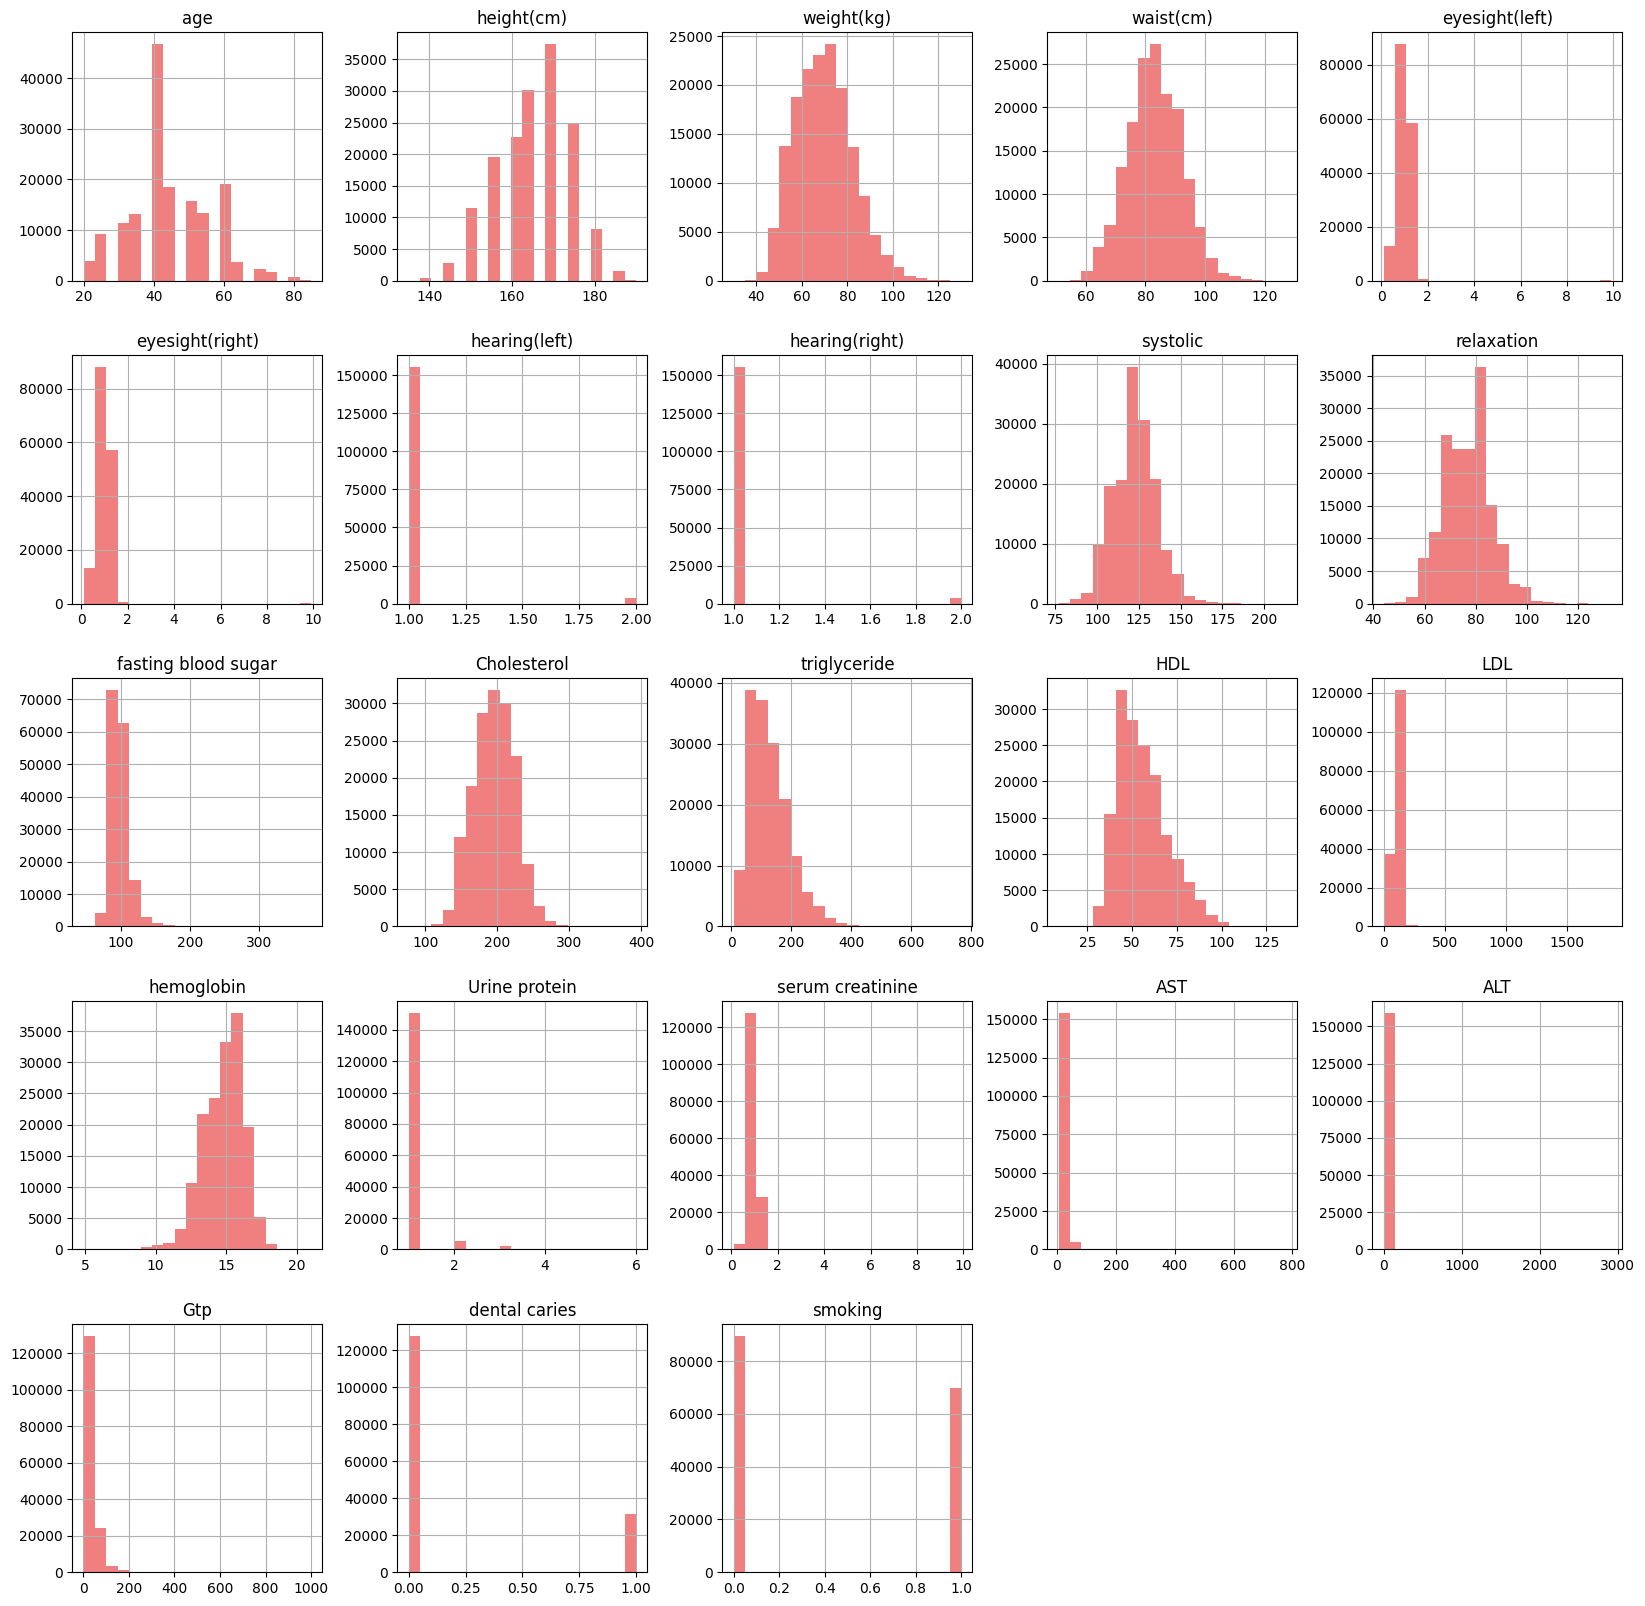

In [12]:
labeled_data.hist(bins=20, figsize=(20,20), color='lightcoral')
plt.show()

smoking
0    56.26
1    43.74
Name: proportion, dtype: float64


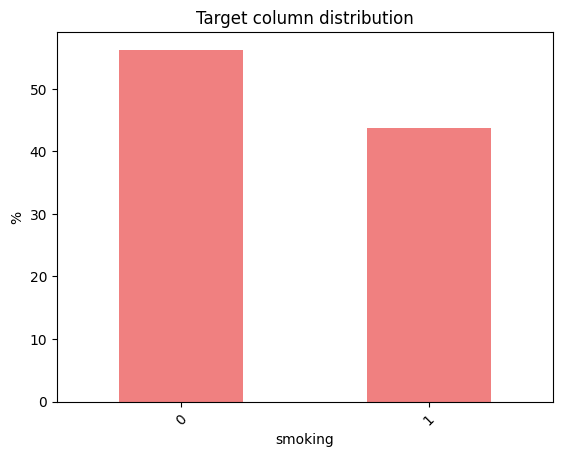

In [13]:
value_counts = labeled_data['smoking'].value_counts(normalize=True)*100
print(value_counts.round(2))
value_counts.plot(kind='bar', color='lightcoral')
plt.title('Target column distribution')
plt.ylabel('%')
plt.xticks(rotation=45)
plt.show()

We have some data imbalance. 

Therefore, in addition to the target metric **ROC-AUC**, we will also pay attention to **PR-AUC**.

### Correlation analysis

Correlation analysis can be a useful tool in feature importance analysis, although it has limitations. Correlation matrix contains only information about the linear relationship of two features.

<Axes: >

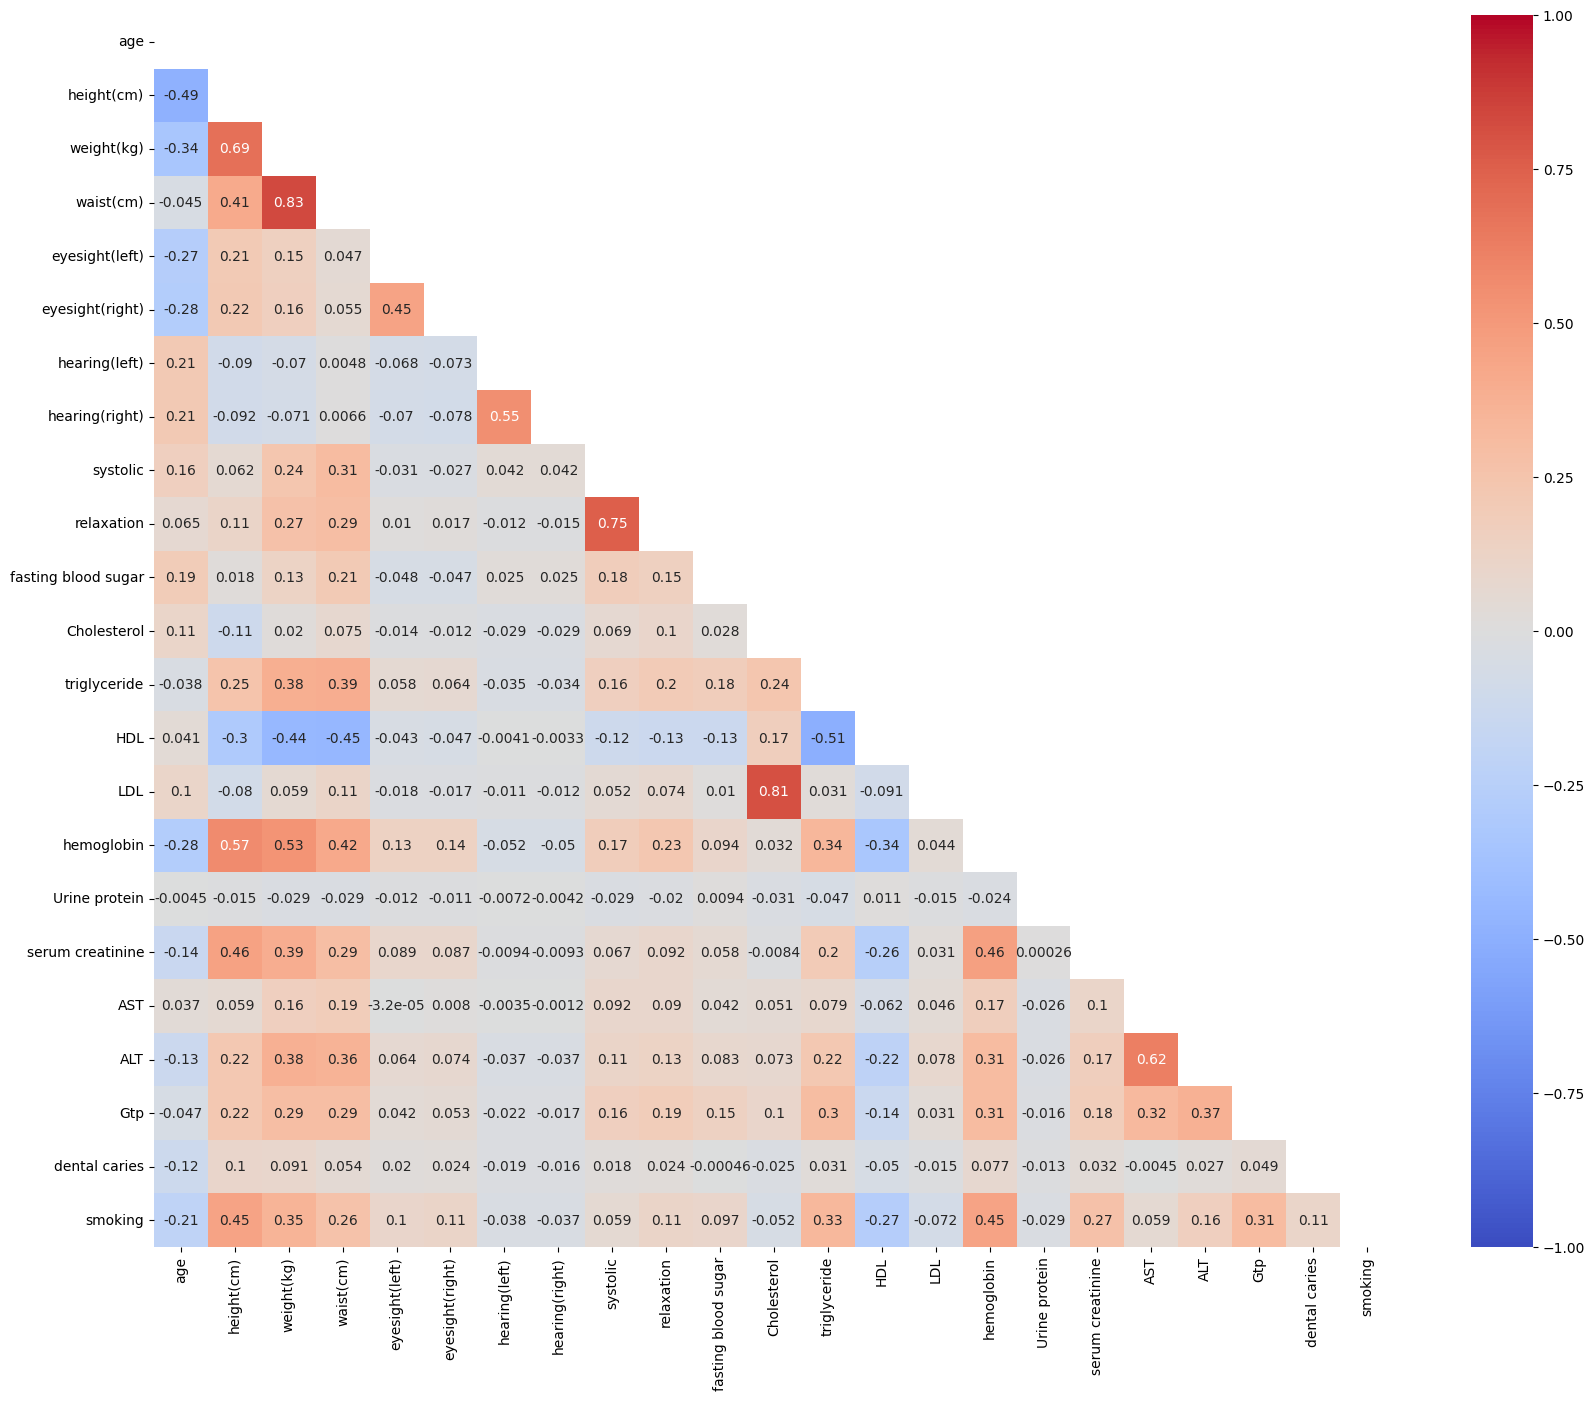

In [14]:
mask = np.zeros_like(labeled_data.corr(),dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,16))
sns.heatmap(labeled_data.corr(), cmap="coolwarm", mask=mask, vmin=-1,vmax=1,center=0, annot=True)

In [15]:
print("Mutual Information between smoking and...")
for column in [
    'hearing(left)', 
    'hearing(right)', 
    'dental caries']:
    mutual_info = mutual_info_score(labeled_data['smoking'], labeled_data[column])
    print(f'{column}: {round(mutual_info, 4)}')

Mutual Information between smoking and...
hearing(left): 0.0008
hearing(right): 0.0007
dental caries: 0.0056


### Adversarial validation

Let's estimate and evaluate degree of similarity between training and testing datasets in terms of feature distribution.

The main goal is to identify if there is a significant discrepancy between the distributions of the two datasets, as this discrepancy can potentially lead to poor model generalization and predictive performance. 

In [16]:
for column in labeled_data.drop('smoking', axis=1).columns:
    print(f'{column}; unique values in train data: {labeled_data[column].nunique()}')
    print(f'{column}; unique values in test data: {test[column].nunique()}')
    print('-----------')

age; unique values in train data: 18
age; unique values in test data: 18
-----------
height(cm); unique values in train data: 14
height(cm); unique values in test data: 16
-----------
weight(kg); unique values in train data: 28
weight(kg); unique values in test data: 26
-----------
waist(cm); unique values in train data: 531
waist(cm); unique values in test data: 508
-----------
eyesight(left); unique values in train data: 20
eyesight(left); unique values in test data: 20
-----------
eyesight(right); unique values in train data: 17
eyesight(right); unique values in test data: 18
-----------
hearing(left); unique values in train data: 2
hearing(left); unique values in test data: 2
-----------
hearing(right); unique values in train data: 2
hearing(right); unique values in test data: 2
-----------
systolic; unique values in train data: 112
systolic; unique values in test data: 114
-----------
relaxation; unique values in train data: 75
relaxation; unique values in test data: 78
----------

In [17]:
np.sort(labeled_data['age'].unique()), np.sort(test['age'].unique())

(array([20, 25, 30, 35, 40, 45, 49, 50, 55, 58, 60, 62, 65, 69, 70, 75, 80,
        85]),
 array([20, 24, 25, 30, 35, 40, 45, 50, 55, 60, 64, 65, 69, 70, 75, 78, 80,
        85]))

In [18]:
labeled_data['age'].mean(), test['age'].mean()

(44.30662581001658, 44.426538320256945)

In [19]:
np.sort(labeled_data['height(cm)'].unique()), np.sort(test['height(cm)'].unique())

(array([135, 139, 140, 145, 150, 155, 160, 165, 170, 175, 180, 181, 185,
        190]),
 array([135, 140, 143, 145, 149, 150, 155, 157, 160, 165, 170, 174, 175,
        180, 185, 190]))

In [20]:
labeled_data['height(cm)'].mean(), test['height(cm)'].mean()

(165.2669287185412, 165.22132220662894)

In [21]:
labeled_data['Urine protein'].unique(), test['Urine protein'].unique()

(array([1, 3, 2, 4, 5, 6]), array([1, 2, 3, 4, 5, 6]))

In [22]:
continuous_features = [
    'waist(cm)', 
    'systolic', 
    'relaxation', 
    'fasting blood sugar', 
    'Cholesterol', 
    'triglyceride', 
    'HDL', 
    'LDL', 
    'hemoglobin', 
    'AST', 
    'ALT', 
    'Gtp',
    'age', 
    'height(cm)', 
    'weight(kg)', 
    'eyesight(left)', 
    'eyesight(right)', 
    # 'Urine protein', 
    'serum creatinine'
    ]

binary_features = [
    'hearing(left)', 
    'hearing(right)', 
    'dental caries']

In [23]:
def distibution_comparison(dataset1, dataset2, column, test, alpha):
    group1 = dataset1[column]
    group2 = dataset2[column]

    statistic, p_value = test(group1, group2)
    print(column)
    if p_value < alpha:
        print('Reject the null hypothesis: Distributions are different')
    else:
        print('Fail to reject the null hypothesis: Distributions are similar')
    print('--------')

In [24]:
for column in continuous_features:
    distibution_comparison(labeled_data, test, column, ks_2samp, 0.01)

waist(cm)
Fail to reject the null hypothesis: Distributions are similar
--------
systolic
Fail to reject the null hypothesis: Distributions are similar
--------
relaxation
Fail to reject the null hypothesis: Distributions are similar
--------
fasting blood sugar
Fail to reject the null hypothesis: Distributions are similar
--------
Cholesterol
Fail to reject the null hypothesis: Distributions are similar
--------
triglyceride
Fail to reject the null hypothesis: Distributions are similar
--------
HDL
Fail to reject the null hypothesis: Distributions are similar
--------
LDL
Fail to reject the null hypothesis: Distributions are similar
--------
hemoglobin
Fail to reject the null hypothesis: Distributions are similar
--------
AST
Fail to reject the null hypothesis: Distributions are similar
--------
ALT
Fail to reject the null hypothesis: Distributions are similar
--------
Gtp
Fail to reject the null hypothesis: Distributions are similar
--------
age
Fail to reject the null hypothesis: Di

In [25]:
# let's compare distributions using Mann-Whitney U Test with significance level 0.01

distibution_comparison(labeled_data, test, 'Urine protein', mannwhitneyu, 0.01)

Urine protein
Fail to reject the null hypothesis: Distributions are similar
--------


In [26]:
for column in binary_features:
    value_counts_train = labeled_data[column].value_counts(normalize=True)*100
    value_counts_test = test[column].value_counts(normalize=True)*100
    print(f'train {column}')
    print(value_counts_train.round(2))
    print(f'test {column}')
    print(value_counts_test.round(2))
    print('---------')

train hearing(left)
hearing(left)
1    97.6
2     2.4
Name: proportion, dtype: float64
test hearing(left)
hearing(left)
1    97.58
2     2.42
Name: proportion, dtype: float64
---------
train hearing(right)
hearing(right)
1    97.66
2     2.34
Name: proportion, dtype: float64
test hearing(right)
hearing(right)
1    97.6
2     2.4
Name: proportion, dtype: float64
---------
train dental caries
dental caries
0    80.2
1    19.8
Name: proportion, dtype: float64
test dental caries
dental caries
0    80.45
1    19.55
Name: proportion, dtype: float64
---------


In [27]:
alpha = 0.01
for column in binary_features:
    sample1 = labeled_data[column]
    sample2 = test[column]
    contingency_table = pd.crosstab(sample1, sample2)
    chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
    if p_chi2 < alpha:
        print("Chi-squared test: Reject the null hypothesis")
        print("There is a significant association between the two samples.")
    else:
        print("Chi-squared test: Fail to reject the null hypothesis")
        print("There is no significant association between the two samples; the distributions are similar or independent of each other")


Chi-squared test: Fail to reject the null hypothesis
There is no significant association between the two samples; the distributions are similar or independent of each other
Chi-squared test: Fail to reject the null hypothesis
There is no significant association between the two samples; the distributions are similar or independent of each other
Chi-squared test: Fail to reject the null hypothesis
There is no significant association between the two samples; the distributions are similar or independent of each other


### Feature distribution analysis between the two classes

In [28]:
np.sort(labeled_data[labeled_data.smoking == 1]['age'].unique()), np.sort(labeled_data[labeled_data.smoking == 0]['age'].unique())

(array([20, 25, 30, 35, 40, 45, 50, 55, 58, 60, 65, 70, 75, 80, 85]),
 array([20, 25, 30, 35, 40, 45, 49, 50, 55, 60, 62, 65, 69, 70, 75, 80, 85]))

In [29]:
# Perhaps there is some data bias
labeled_data[labeled_data.smoking == 1]['age'].mean(), labeled_data[labeled_data.smoking == 0]['age'].mean()

(41.53928761144531, 46.45781949265091)

In [30]:
labeled_data[labeled_data.smoking == 1]['height(cm)'].mean(), labeled_data[labeled_data.smoking == 0]['height(cm)'].mean()

(169.7391497853646, 161.7904422842985)

In [31]:
# it seems like our data doesn't confirm a potential link between smoking and higher urine protein levels
value_counts_train = labeled_data[labeled_data.smoking == 1]['Urine protein'].value_counts(normalize=True)*100
value_counts_test = labeled_data[labeled_data.smoking == 0]['Urine protein'].value_counts(normalize=True)*100
print('train')
print(value_counts_train.round(2))
print('test')
print(value_counts_test.round(2))

train
Urine protein
1    95.55
2     2.96
3     1.19
4     0.27
5     0.04
Name: proportion, dtype: float64
test
Urine protein
1    94.09
2     3.96
3     1.56
4     0.32
5     0.05
6     0.01
Name: proportion, dtype: float64


In [32]:
# let's compare distributions using Mann-Whitney U Test with significance level 0.01

group1 = labeled_data[labeled_data.smoking == 1]['Urine protein']
group2 = labeled_data[labeled_data.smoking == 0]['Urine protein']

u_stat, p_value = mannwhitneyu(group1, group2)

if p_value < 0.01:
    print("Reject the null hypothesis: Distributions are different.")
else:
    print("Fail to reject the null hypothesis: Distributions are similar.")

Reject the null hypothesis: Distributions are different.


In [33]:
for column in continuous_features:
    group1 = labeled_data[labeled_data.smoking == 1][column]
    group2 = labeled_data[labeled_data.smoking == 0][column]
    # Perform the Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(group1, group2)
    print(column)
    if p_value < 0.01:
        print('Reject the null hypothesis: Distributions are different')
    else:
        print('Fail to reject the null hypothesis: Distributions are similar')
    print('--------')

waist(cm)
Reject the null hypothesis: Distributions are different
--------
systolic
Reject the null hypothesis: Distributions are different
--------
relaxation
Reject the null hypothesis: Distributions are different
--------
fasting blood sugar
Reject the null hypothesis: Distributions are different
--------
Cholesterol
Reject the null hypothesis: Distributions are different
--------
triglyceride
Reject the null hypothesis: Distributions are different
--------
HDL
Reject the null hypothesis: Distributions are different
--------
LDL
Reject the null hypothesis: Distributions are different
--------
hemoglobin
Reject the null hypothesis: Distributions are different
--------
AST
Reject the null hypothesis: Distributions are different
--------
ALT
Reject the null hypothesis: Distributions are different
--------
Gtp
Reject the null hypothesis: Distributions are different
--------
age
Reject the null hypothesis: Distributions are different
--------
height(cm)
Reject the null hypothesis: Distri

In [34]:
alpha = 0.01
for column in binary_features:
    sample1 = labeled_data[labeled_data.smoking == 1][column]
    sample2 = labeled_data[labeled_data.smoking == 1][column]
    contingency_table = pd.crosstab(sample1, sample2)
    chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
    if p_chi2 < alpha:
        print("Chi-squared test: Reject the null hypothesis")
        print("There is a significant association between the two samples.")
    else:
        print("Chi-squared test: Fail to reject the null hypothesis")
        print("There is no significant association between the two samples; the distributions are similar or independent of each other")

Chi-squared test: Reject the null hypothesis
There is a significant association between the two samples.
Chi-squared test: Reject the null hypothesis
There is a significant association between the two samples.
Chi-squared test: Reject the null hypothesis
There is a significant association between the two samples.


# Data Preparation

In [35]:
train, val = train_test_split(labeled_data, test_size=0.1, random_state=24, stratify=labeled_data.smoking) 
# create subsample (10% of train) for faster model fine-tuning
_, subsample = train_test_split(train, test_size=0.1, random_state=24, stratify=train.smoking) 

In [36]:
X_tr = train.iloc[:, :-1]
y_tr = train.iloc[:, -1]

X_val = val.iloc[:, :-1]
y_val = val.iloc[:, -1]

X_test = test

X_subsample = subsample.iloc[:, :-1]
y_subsample = subsample.iloc[:, -1]
    
# let's add a few new features (actually they help just a little bit)  

feature_eng(X_tr)
feature_eng(X_val)
feature_eng(X_test)
feature_eng(X_subsample)

# Modeling and Validation

Let's search for good parameter values for the models using grid search along with 5-Fold Cross Validation (using 10% of the data for the Random Forest and Gradient-Boosted Decision Trees algorithms) previously set aside for training. Then, we will train the model with the best parameters on all training data and validate it on separate validation data.

In [37]:
def grid_search(model, param_grid, X_train, y_train, X_validation, y_validation):
    
    start_time = time.time()
    search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_validation_pred = best_model.predict_proba(X_validation)[:, 1]
    roc_auc = roc_auc_score(y_validation, y_validation_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("Best Parameters:", search.best_params_)
    print("Best Cross-Validation ROC-AUC):", search.best_score_)
    print("ROC AUC on validation:", roc_auc)

    return search

Since we previously detected a slight data imbalance, we will also pay attention to the PR-AUC metric.

Additionally, on the output, binary labels are likely to be more preferable, which requires selecting a threshold. Therefore, we will look at the recall, precision, and F1 metrics for various threshold values.

In [38]:
def metrics_viz(model, X, y):
    
    y_pred = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred)
    precision, recall, _ = precision_recall_curve(y, y_pred)
    
    f_metrics = []
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for th in thresholds:
        f_metrics.append({
            'positives_ratio': (y_pred >= th).sum()/y_pred.shape[0],
            'precision': precision_score(y, y_pred >= th),
            'recall': recall_score(y, y_pred >= th),
            'f1': f1_score(y, y_pred >= th),
        })
    print(pd.DataFrame(f_metrics, index=thresholds).round(3))

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    score = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, marker='.')
    axs[0].set_title(f'ROC-AUC = {score:.3f}')
    axs[0].set_xlabel('Fall-out')
    axs[0].set_ylabel('Recall')
    axs[0].legend()

    axs[1].plot(recall, precision, marker='.')
    axs[1].set_title(f'PR-AUC = {auc(recall, precision):.3f}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()

    plt.show()
    
    return score

### Logistic Regression
Searching of the appropriate inverse of regularization strength and Elastic-Net mixing parameter value using 5-fold Cross-Validation

In [39]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', 
                                      max_iter=10000, 
                                      random_state=1))
])

param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0, 20.0],
    }

search_lr = grid_search(pipeline_lr, param_grid_lr, X_tr, y_tr, X_val, y_val)

Elapsed Time: 39.00 seconds
Best Parameters: {'classifier__C': 0.1}
Best Cross-Validation ROC-AUC): 0.8364285026593639
ROC AUC on validation: 0.8290950984616836


In [40]:
best_model = search_lr.best_estimator_
coefficients = best_model.named_steps['classifier'].coef_
print("Coefficients of the linear regression:", coefficients)

Coefficients of the linear regression: [[-1.61020498e-02  1.48261768e+00 -1.47082491e+00  2.46161568e-02
   2.76438358e-04  2.10068943e-02  2.63855524e-03  1.10389882e-02
  -1.61857149e-01  5.83105095e-02  9.40680889e-02 -1.11573274e-01
   1.83634248e-01 -2.09350561e-01  7.29303254e-02  6.90687498e-01
  -4.12988760e-02  8.52434239e-03 -1.08227682e-01 -7.18786449e-02
   6.16105100e-01  1.40945062e-01  9.27696467e-01  2.11438118e-01
  -8.78896506e-02 -2.96307557e-01  5.96237829e-02]]


In [41]:
results = search_lr.cv_results_
for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    lower_bound = mean_score - 3 * std_score
    upper_bound = mean_score + 3 * std_score
    print(f"Mean 5-fold CV ROC-AUC: {mean_score:.4f}, Params: {params}")
    print(f"Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

Mean 5-fold CV ROC-AUC: 0.8355, Params: {'classifier__C': 0.001}
Confidence Interval: (0.8265, 0.8445)
Mean 5-fold CV ROC-AUC: 0.8363, Params: {'classifier__C': 0.01}
Confidence Interval: (0.8275, 0.8452)
Mean 5-fold CV ROC-AUC: 0.8364, Params: {'classifier__C': 0.1}
Confidence Interval: (0.8279, 0.8450)
Mean 5-fold CV ROC-AUC: 0.8364, Params: {'classifier__C': 1.0}
Confidence Interval: (0.8279, 0.8448)
Mean 5-fold CV ROC-AUC: 0.8364, Params: {'classifier__C': 10.0}
Confidence Interval: (0.8279, 0.8448)
Mean 5-fold CV ROC-AUC: 0.8364, Params: {'classifier__C': 20.0}
Confidence Interval: (0.8279, 0.8448)


     positives_ratio  precision  recall     f1
0.1            0.800      0.540   0.987  0.698
0.2            0.701      0.601   0.964  0.741
0.3            0.632      0.638   0.923  0.754
0.4            0.557      0.668   0.851  0.748
0.5            0.469      0.698   0.748  0.722
0.6            0.363      0.729   0.604  0.661
0.7            0.239      0.767   0.419  0.542
0.8            0.119      0.793   0.216  0.340
0.9            0.034      0.824   0.064  0.118


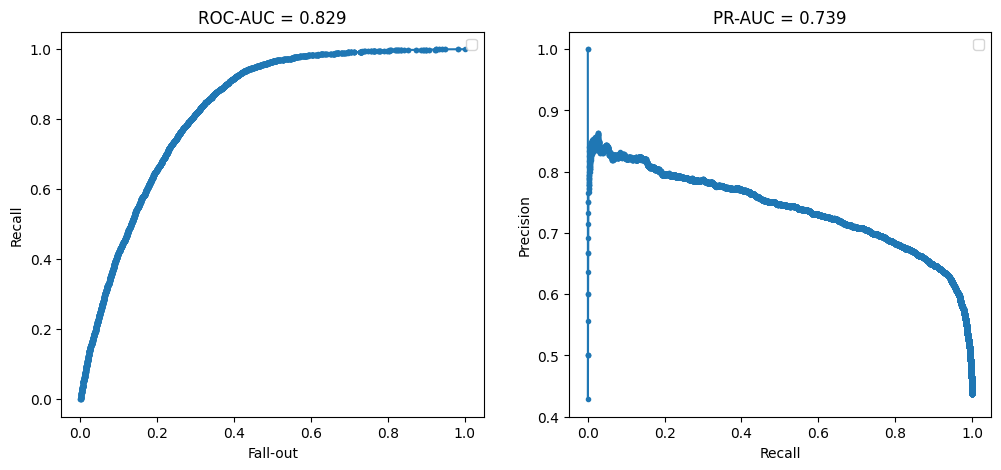

In [42]:
pipeline_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            C=search_lr.best_params_['classifier__C'],
            max_iter=10000,
            random_state=1))
    ])

pipeline_lr.fit(X_tr, y_tr)
score_lr = metrics_viz(pipeline_lr, X_val, y_val)

In [43]:
perm = PermutationImportance(pipeline_lr, random_state=1).fit(X_val, y_val)
show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.1726 ± 0.0083,height(cm)
0.0646 ± 0.0021,BMI
0.0471 ± 0.0020,weight(kg)
0.0447 ± 0.0041,hemoglobin
0.0324 ± 0.0046,Gtp
0.0108 ± 0.0015,LDL-triglyceride Ratio
0.0055 ± 0.0019,systolic
0.0055 ± 0.0010,triglyceride
0.0054 ± 0.0019,HDL
0.0024 ± 0.0015,dental caries


### Sklearn Random Forest

In [44]:
param_grid_rf = {
        'n_estimators': [100, 400, 700], 
        'max_depth': [20, 40],  
        'min_samples_split': [2, 5] 
    }

search_rf = grid_search(RandomForestClassifier(random_state=1),
                        param_grid_rf,
                        X_subsample, 
                        y_subsample, 
                        X_val, 
                        y_val)

Elapsed Time: 344.19 seconds
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 700}
Best Cross-Validation ROC-AUC): 0.8530669988669155
ROC AUC on validation: 0.8427984935598328


In [45]:
results = search_rf.cv_results_
for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    lower_bound = mean_score - 3 * std_score
    upper_bound = mean_score + 3 * std_score
    print(f"Mean 5-fold CV ROC-AUC: {mean_score:.4f}, Params: {params}")
    print(f"Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

Mean 5-fold CV ROC-AUC: 0.8491, Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Confidence Interval: (0.8318, 0.8663)
Mean 5-fold CV ROC-AUC: 0.8523, Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 400}
Confidence Interval: (0.8340, 0.8705)
Mean 5-fold CV ROC-AUC: 0.8531, Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 700}
Confidence Interval: (0.8348, 0.8713)
Mean 5-fold CV ROC-AUC: 0.8496, Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Confidence Interval: (0.8300, 0.8693)
Mean 5-fold CV ROC-AUC: 0.8528, Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 400}
Confidence Interval: (0.8324, 0.8731)
Mean 5-fold CV ROC-AUC: 0.8531, Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 700}
Confidence Interval: (0.8328, 0.8733)
Mean 5-fold CV ROC-AUC: 0.8500, Params: {'max_depth': 40, 'min_samples_split': 2, 'n_estimators': 100}
Confidence Interval: (0.8304, 0.8695)
Mean 5-fold C

Let's train the RF on the whole training data X_tr

     positives_ratio  precision  recall     f1
0.1            0.762      0.565   0.984  0.718
0.2            0.706      0.601   0.971  0.742
0.3            0.656      0.633   0.949  0.759
0.4            0.593      0.665   0.902  0.765
0.5            0.509      0.703   0.818  0.757
0.6            0.396      0.748   0.677  0.711
0.7            0.248      0.803   0.455  0.580
0.8            0.094      0.871   0.188  0.309
0.9            0.005      0.975   0.011  0.022


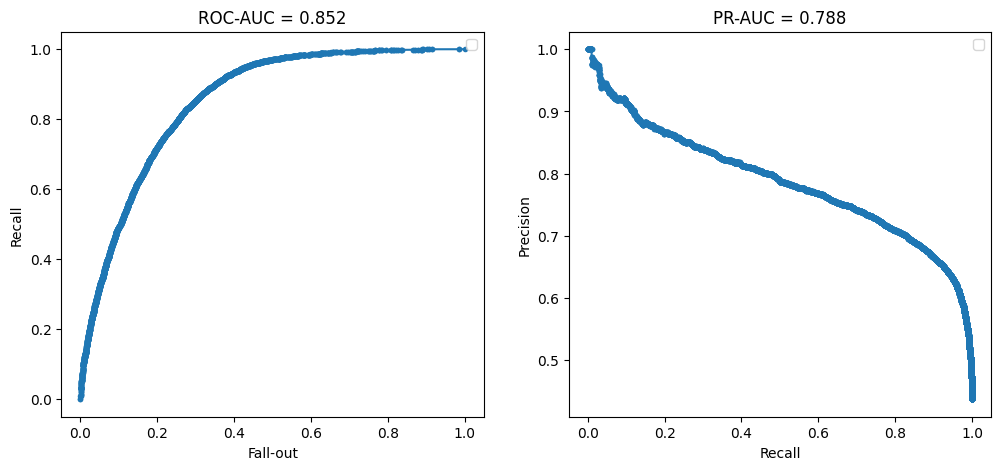

In [46]:
n_estimators = search_rf.best_params_['n_estimators']
max_depth = search_rf.best_params_['max_depth']
min_samples_split = search_rf.best_params_['min_samples_split']

rf = RandomForestClassifier(n_estimators=n_estimators, 
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split, 
                            random_state=1)

rf.fit(X_tr, y_tr)
score_rf = metrics_viz(rf, X_val, y_val)

Let's use again Permutation Importance

In [47]:
perm = PermutationImportance(rf, random_state=1).fit(X_val, y_val)
show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.0428 ± 0.0025,Gtp
0.0397 ± 0.0018,height(cm)
0.0334 ± 0.0058,hemoglobin
0.0080 ± 0.0017,age
0.0032 ± 0.0010,ALT
0.0025 ± 0.0017,AST
0.0024 ± 0.0013,serum creatinine
0.0017 ± 0.0013,systolic
0.0015 ± 0.0006,LDL-triglyceride Ratio
0.0014 ± 0.0015,BMI


GINI importance (based on GINI impurity)

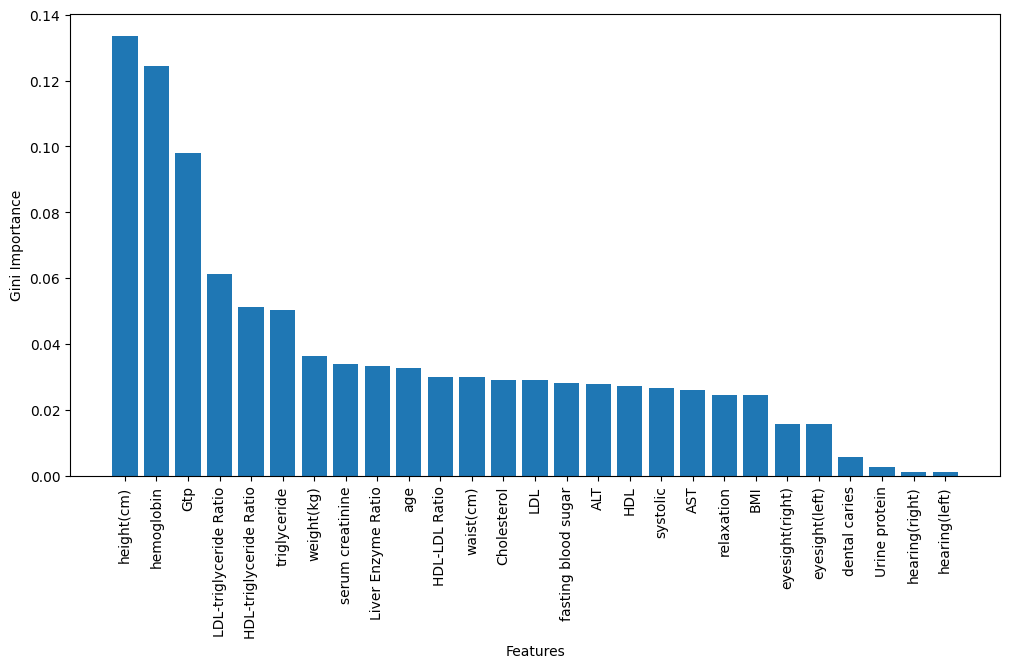

In [48]:
gini_importances = rf.feature_importances_

sorted_indices = gini_importances.argsort()[::-1]
sorted_feature_names = [X_tr.columns[i] for i in sorted_indices]
sorted_importances = gini_importances[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Gini Importance')
plt.show()

### Gradient-Boosted Decision Trees from LGBM

In [49]:
param_grid_lgbm = {
        'n_estimators': [100, 500, 1000],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_lambda': [0.1, 1.0, 10.0]
    }


search_lgbm = grid_search(lgb.LGBMClassifier(random_state=1),
                        param_grid_lgbm,
                        X_subsample, 
                        y_subsample, 
                        X_val, 
                        y_val)

Elapsed Time: 466.13 seconds
Best Parameters: {'colsample_bytree': 0.8, 'n_estimators': 100, 'reg_lambda': 10.0, 'subsample': 0.8}
Best Cross-Validation ROC-AUC): 0.8559248339846048
ROC AUC on validation: 0.8501500119405516


In [50]:
results = search_lgbm.cv_results_
for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    lower_bound = mean_score - 3 * std_score
    upper_bound = mean_score + 3 * std_score
    print(f"Mean 5-fold CV ROC-AUC: {mean_score:.4f}, Params: {params}")
    print(f"Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

Mean 5-fold CV ROC-AUC: 0.8542, Params: {'colsample_bytree': 0.8, 'n_estimators': 100, 'reg_lambda': 0.1, 'subsample': 0.8}
Confidence Interval: (0.8339, 0.8745)
Mean 5-fold CV ROC-AUC: 0.8542, Params: {'colsample_bytree': 0.8, 'n_estimators': 100, 'reg_lambda': 0.1, 'subsample': 1.0}
Confidence Interval: (0.8339, 0.8745)
Mean 5-fold CV ROC-AUC: 0.8551, Params: {'colsample_bytree': 0.8, 'n_estimators': 100, 'reg_lambda': 1.0, 'subsample': 0.8}
Confidence Interval: (0.8351, 0.8752)
Mean 5-fold CV ROC-AUC: 0.8551, Params: {'colsample_bytree': 0.8, 'n_estimators': 100, 'reg_lambda': 1.0, 'subsample': 1.0}
Confidence Interval: (0.8351, 0.8752)
Mean 5-fold CV ROC-AUC: 0.8559, Params: {'colsample_bytree': 0.8, 'n_estimators': 100, 'reg_lambda': 10.0, 'subsample': 0.8}
Confidence Interval: (0.8384, 0.8734)
Mean 5-fold CV ROC-AUC: 0.8559, Params: {'colsample_bytree': 0.8, 'n_estimators': 100, 'reg_lambda': 10.0, 'subsample': 1.0}
Confidence Interval: (0.8384, 0.8734)
Mean 5-fold CV ROC-AUC: 0.

     positives_ratio  precision  recall     f1
0.1            0.732      0.585   0.979  0.732
0.2            0.681      0.619   0.964  0.753
0.3            0.634      0.645   0.936  0.764
0.4            0.575      0.678   0.890  0.770
0.5            0.498      0.714   0.813  0.760
0.6            0.407      0.753   0.700  0.725
0.7            0.286      0.799   0.523  0.632
0.8            0.141      0.857   0.277  0.418
0.9            0.017      0.964   0.038  0.073


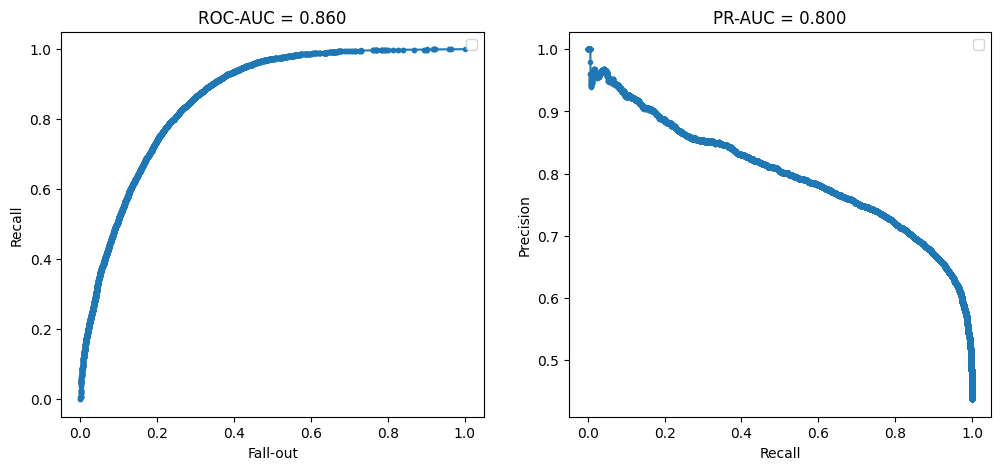

In [51]:
n_estimators = search_lgbm.best_params_['n_estimators']
subsample = search_lgbm.best_params_['subsample']
colsample_bytree = search_lgbm.best_params_['colsample_bytree']
reg_lambda = search_lgbm.best_params_['reg_lambda']

lgbm_classifier = lgb.LGBMClassifier(n_estimators=n_estimators,
                                     subsample=subsample,
                                     colsample_bytree=colsample_bytree,
                                     reg_lambda=reg_lambda,
                                     random_state=1)
lgbm_classifier.fit(X_tr, y_tr)
score_lgbm = metrics_viz(lgbm_classifier, X_val, y_val)

Feature importance

https://github.com/Microsoft/LightGBM/issues/1842

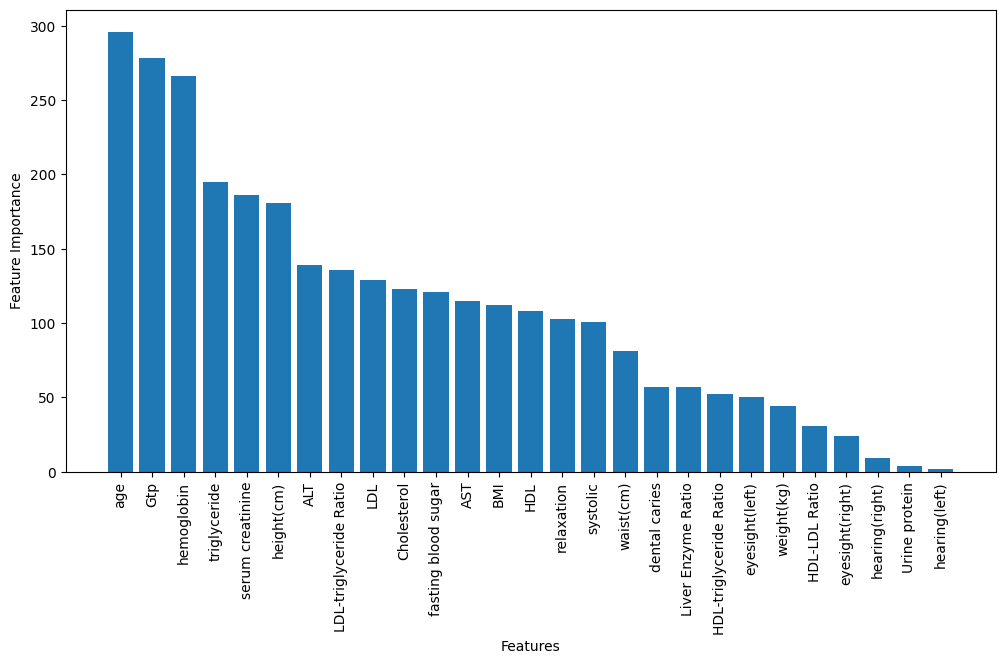

In [52]:
importances = lgbm_classifier.feature_importances_

sorted_indices = importances.argsort()[::-1]
sorted_feature_names = [X_tr.columns[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

Permutation Feature Importance

In [53]:
perm = PermutationImportance(lgbm_classifier, random_state=1).fit(X_val, y_val)
show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.0502 ± 0.0031,Gtp
0.0446 ± 0.0027,height(cm)
0.0396 ± 0.0029,hemoglobin
0.0123 ± 0.0034,age
0.0062 ± 0.0036,LDL-triglyceride Ratio
0.0045 ± 0.0027,ALT
0.0041 ± 0.0019,serum creatinine
0.0037 ± 0.0013,BMI
0.0036 ± 0.0027,triglyceride
0.0019 ± 0.0023,fasting blood sugar


### Model Testing

In [54]:
models = [pipeline_lr, rf, lgbm_classifier]
scores = [score_lr, score_rf, score_lgbm]
for model, score in zip(models, scores):
    print(type(model).__name__)
    print('ROC-AUC on validation:', score)
    print('---------------------------------------')
    y_test_pred = model.predict_proba(X_test.drop('id', axis=1))[:, 1]
    sample_submission['smoking'] = y_test_pred
    sample_submission.to_csv(f'submission{type(model).__name__}.csv', index=False)
    

Pipeline
ROC-AUC on validation: 0.8290940730402855
---------------------------------------
RandomForestClassifier
ROC-AUC on validation: 0.8524054743723559
---------------------------------------
LGBMClassifier
ROC-AUC on validation: 0.8600822916694204
---------------------------------------


### Results on test data:
- Logistic Regression: 0.83963

- Random Forest: 0.86025

- Gradient-Boosted Decision Trees: 0.86634


![testing](./images/kaggle_testing.png)